In [1]:
import os
import itertools
import sys
import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras.applications.resnet50 import ResNet50
from keras import backend as K
from keras.callbacks import Callback
from keras.layers import Dense
from keras.models import Model
from PIL import Image
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score)

%matplotlib inline

Using TensorFlow backend.


boilerplate code

In [2]:
def xml_to_labels(xml_data, unique_labels):
    root = ET.XML(xml_data)
    labels = set() if unique_labels else []
    labels_add = labels.add if unique_labels else labels.append
    for i, child in enumerate(root):
        if child.tag == 'filename':
            img_filename = child.text
        if child.tag == 'object':
            for subchild in child:
                if subchild.tag == 'name':
                    labels_add(subchild.text)
    return img_filename, list(labels)

def get_labels(annotations_dir, unique_labels=True):
    for annotation_file in annotations_dir.iterdir():
        with open(annotation_file) as f:
            yield xml_to_labels(f.read(), unique_labels)
            
def plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(title)
    ax.grid(False)
    
def plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False):
    fig, axes = plt.subplots(int(np.ceil(len(label_to_class) / 2)), 2, figsize=(15, 60))
    axes = axes.flatten()
    for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
        tn, fp, fn, tp = conf_matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
        recall = tp / (tp + fn + sys.float_info.epsilon)
        precision = tp / (tp + fp + sys.float_info.epsilon)
        plot_confusion_matrix(
            np.array([[tp, fn], [fp, tn]]),
            classes=['+', '-'],
            title=f'Label: {label_to_class[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}',
            ax=axes[i]
        )
        plt.tight_layout()
    if save_plot:
        plt.savefig('confusion_matrices.png', dpi=50)

class Metrics(Callback):
    def __init__(self, validation_generator, validation_steps=None, threshold=0.5):
        self.validation_generator = validation_generator
        self.validation_steps = validation_steps or len(validation_generator)
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.val_f1_scores = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        gen_1, gen_2 = itertools.tee(self.validation_generator)
        y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
        y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')
        _val_f1 = f1_score(y_true, y_pred, average='weighted')
        _val_recall = recall_score(y_true, y_pred, average='weighted')
        _val_precision = precision_score(y_true, y_pred, average='weighted')
        self.val_f1_scores.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" - val_f1_score: {_val_f1:.5f} - val_precision: {_val_precision:.5f} - val_recall: {_val_recall:.5f}")
        return

In [3]:
pd.set_option('display.max_colwidth', 70)
plt.rcParams['figure.figsize'] = (25, 6)
sns.set(font_scale=2)
sns.set_style('ticks')

# Multi-label classification with Keras' `ImageDataGenerator`

- Author: Rodrigo Agundez
- Date: January 28, 2019

This notebook demonstrates how to use the `ImageDataGenerator` from `Keras` to solve a multi-label classification problem. That is a classification problem where each image can have multiple class labels.

The dataset used for this demonstration is [VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/). For classification this dataset contains ~17,000 images and 20 classes.

## Prerequisites

Note: make sure you are in a virtual environment as this notebook will install the development verions of `keras-preprocessing` and `scikit-learn`.

In order to run this notebook you need:

    - keras
    - keras-preprocessing
    - matplotlib
    - numpy
    - pandas
    - Pillow
    - seaborn

**Update `keras-preprocessing` to the latests version in github.**

In [4]:
!python -m pip install -U keras-preprocessing

    100% |████████████████████████████████| 61kB 6.2MB/s ta 0:00:011
  Found existing installation: Keras-Preprocessing 1.0.6
    Uninstalling Keras-Preprocessing-1.0.6:
      Successfully uninstalled Keras-Preprocessing-1.0.6


**Update `scikit-learn` to the latests version in github.**

In [6]:
!pip install git+https://www.github.com/scikit-learn/scikit-learn.git --upgrade

imports from the updated versions of the packages

In [5]:
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import multilabel_confusion_matrix

## About ImageDataGenerator

`ImageDataGenerator` is a known Keras class which has 2 main functionalities:

 - Data augmentation
 
 This is a technique which can reduce the overfitting by increasing the amount of observations in the training data. In the case of images this is done via [affine Transformations](https://homepages.inf.ed.ac.uk/rbf/HIPR2/affine.htm) for example.
 
 
 - Loading image data from disk
 
 This allows the user to train over more data than the one that is able to fit in memory.

### About `flow_from_directory`

The most known use of `ImageDataGenerator` is via its `flow_from_directory` method, which allows you to do several tasks but it's restrcited to the following directory structure of your data:

![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

* You can read more about it in this [blog post](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720) or in the [Keras documentation](https://keras.io/preprocessing/image/).

### About `flow_from_dataframe`

In order to provide Keras users with a more flexible API and keeping the two main advantages, the method `flow_from_dataframe` was introduced. Under the hood the mechanics are handle by the `DataFrameIterator` class which will cover a wide variety of cases that `flow_from_directory` is not able to do.

* You can read more aobut it in this [blog post](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)

In particular I recently added the functionality to perform `multi-class` classification, and this notebook concentrates on this topic.

* This was possible before but in a hacky not very API friendly way. You can read about it [here](https://github.com/keras-team/keras-preprocessing/issues/135).

## Multi-label classification

A multi-label classification scenario exists when a single observation (images in this example) can have multiple class labels. Let's take an example from the VOC2010 dataset:
* Not to be confused with multi-class classification where there are more than 2 classes but each observation has a single class label.

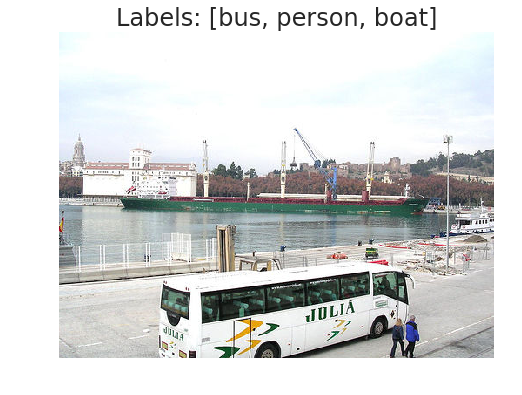

In [6]:
plt.imshow(plt.imread(Path('~/.keras/datasets/VOC2012/JPEGImages/2008_007056.jpg').expanduser()))
plt.title('Labels: [bus, person, boat]')
plt.axis('off');

## Collecting images filenames and labels

Download the [VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar) dataset and make sure `Annotations` and `JPEGImages` are under the `VOC2012` directory. Below an example of the folder structure and some file examples.

In [7]:
!cd ~/.keras/datasets && tree VOC2012 -l -L 2 -P 201[0-1]_00000[2-3].* 

VOC2012
├── Annotations
│   ├── 2010_000002.xml
│   ├── 2010_000003.xml
│   ├── 2011_000002.xml
│   └── 2011_000003.xml
├── ImageSets
│   ├── Action
│   ├── Layout
│   ├── Main
│   └── Segmentation
├── JPEGImages
│   ├── 2010_000002.jpg
│   ├── 2010_000003.jpg
│   ├── 2011_000002.jpg
│   └── 2011_000003.jpg
├── SegmentationClass
│   ├── 2010_000002.png
│   ├── 2010_000003.png
│   └── 2011_000003.png
└── SegmentationObject
    ├── 2010_000002.png
    ├── 2010_000003.png
    └── 2011_000003.png

9 directories, 14 files


The path to the images can be loaded into the DataFrame as relative or absolute paths. In this example we will use relative paths and then use the directory parameter. The labels can be loaded in a list, tuple or string if only one. Below a sample of the dataframe with the filenames and labels for our dataset.

In [8]:
annotations_dir = Path('~/.keras/datasets/VOC2012/Annotations').expanduser()
images_dir = Path('~/.keras/datasets/VOC2012/JPEGImages').expanduser()

In [9]:
img_metadata = pd.DataFrame(get_labels(annotations_dir), columns=['filename', 'labels'])
print(f'Found {len(img_metadata)} images')
img_metadata.sample(5)

Found 17125 images


,filename,labels
11212,2008_004161.jpg,[person]
10860,2011_005933.jpg,[person]
4324,2011_007188.jpg,[person]
7926,2012_002611.jpg,[person]
12922,2008_003996.jpg,[person]


Let's see how the different classes are represented in the dataset

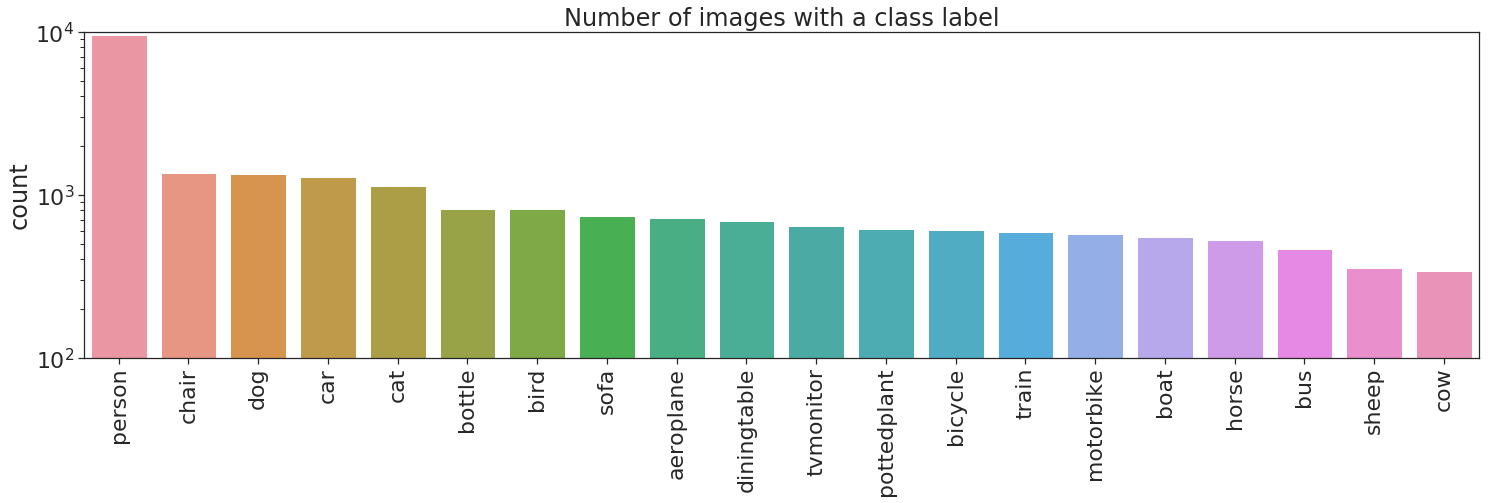

In [10]:
all_labels = [label for lbs in img_metadata['labels'] for label in lbs]
labels_count = Counter(all_labels)
ax = sns.countplot(all_labels, order=[k for k, _ in labels_count.most_common()], log=True)
ax.set_title('Number of images with a class label')
ax.set_ylim(1E2, 1E4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

The classes are imbalanced, we can address that in different ways, for example using sample weights or class weights. For now let's just continue with the functionality.

* Sample weights are not implemented in `flow_from_dataframe` yet, but this functionality is expected to be added soon.

Now let's take a look on how the size of the iamges is distributed accross the dataset

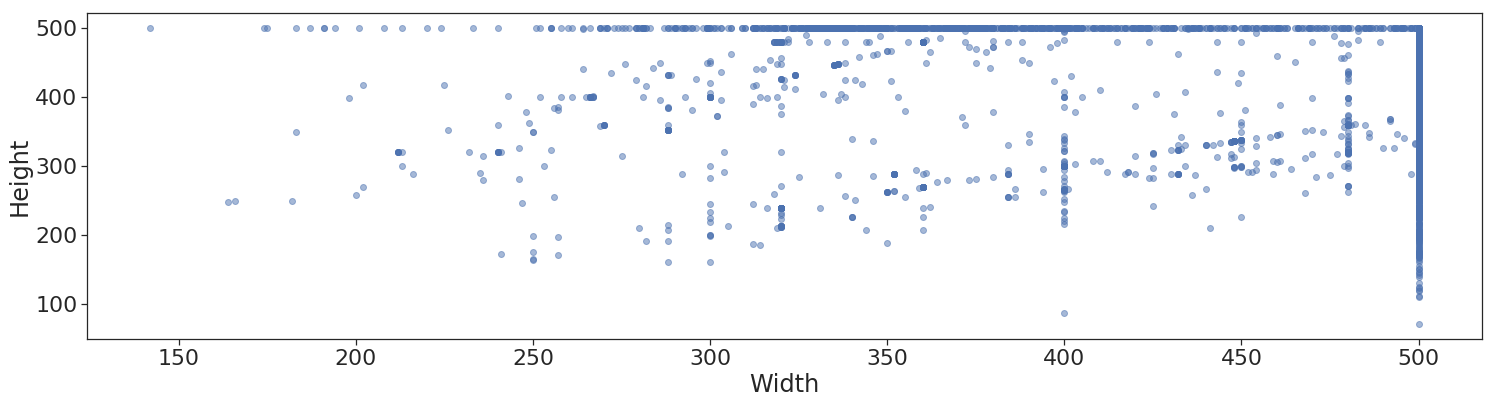

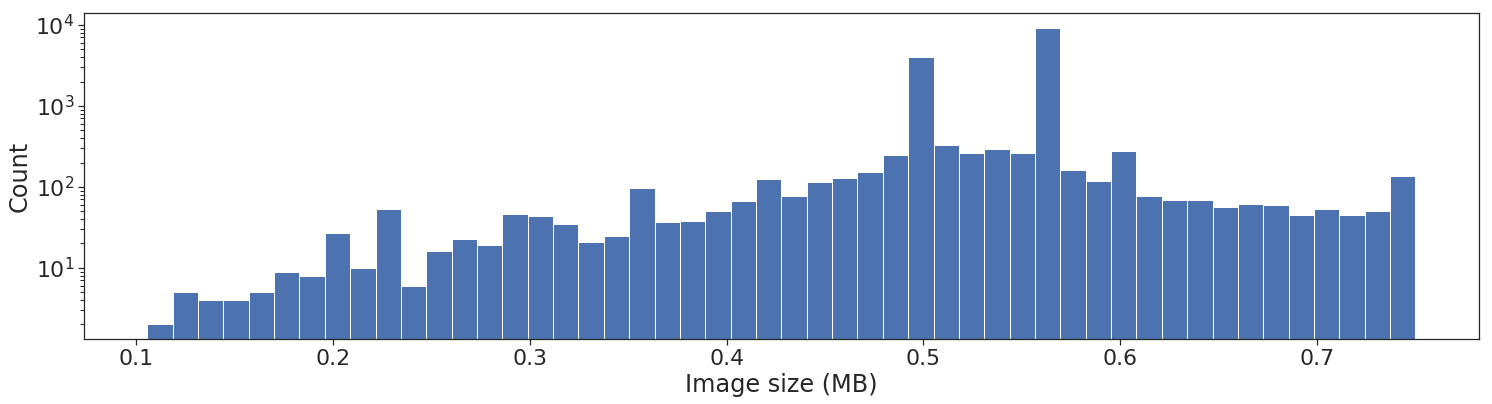

In [11]:
height, width, size = np.empty(len(img_metadata)), np.empty(len(img_metadata)), np.empty(len(img_metadata)) 
for i, img_filepath in img_metadata['filename'].iteritems():
    w, h = Image.open(images_dir.joinpath(img_filepath)).size
    width[i], height[i], size[i] = w, h, w * h * 3 * 1E-6
plt.scatter(width, height, alpha=0.5)
plt.xlabel('Width'); plt.ylabel('Height'); plt.show()
plt.hist(size, bins=50, log=True)
plt.xlabel('Image size (MB)');
plt.ylabel('Count');

As illustrated above, the dataset contains images of different heights and widths. I won't go into detail but this is not really a problem if at the end of the feature extraction via Convolutional layers a Global pooling layer is introduced. Unfortunately when using the `flow_from_dataframe` method all images need to be standarized to the same size, this size is defined via the `target_size` parameter.

* This is because each batch of images is loaded into a numpy array. This would be a nice new feature to have though.

Let's see some examples of the labels and the images in the dataset.

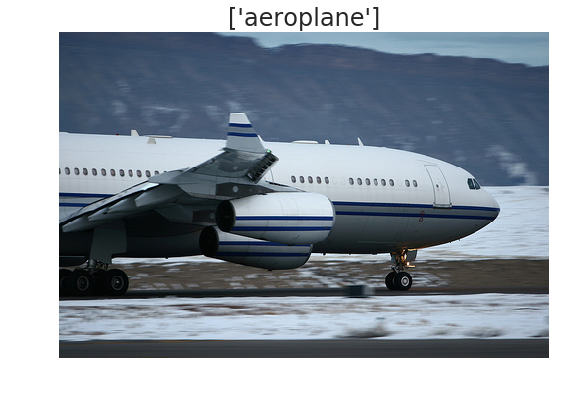

In [12]:
image_directory = Path('VOC2012/JPEGImages')
observation = img_metadata.sample(n=1).to_dict(orient='records')[0]
img = plt.imread(images_dir.joinpath(observation['filename']))
plt.imshow(img)
plt.axis('off')
plt.title(observation['labels']);

## Training the model

First we need to instantiate the `ImageDataGenerator`. I'll do this with a simple setup just normalizing the the pixel values. I also included a validation split to use it for validation stats during training after each epoch.

In [13]:
img_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

We can now create the training and validation `DataFrameIterator`, in the case of multi-label classification the `class_mode` should be `categorical` (which is the default value). Since I defined a `validation_split` the validation batches ca be retrieved by specifying the `subset` as `validation`.

In [14]:
img_iter = img_gen.flow_from_dataframe(
    img_metadata,
    shuffle=True,
    directory=images_dir,
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=20,
    subset='training'
)

img_iter_val = img_gen.flow_from_dataframe(
    img_metadata,
    shuffle=False,
    directory=images_dir,
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=20,
    subset='validation'
)

Found 13700 images belonging to 20 classes.
Found 3425 images belonging to 20 classes.


Let's see some examples of images from the batches being generated

In [15]:
label_to_class = {v: k for k, v in img_iter.class_indices.items()}
def array_to_labels(onehot_array, label_to_class):
    labels = []
    idx = np.where(onehot_array == 1)[0]
    return [label_to_class[i] for i in idx]

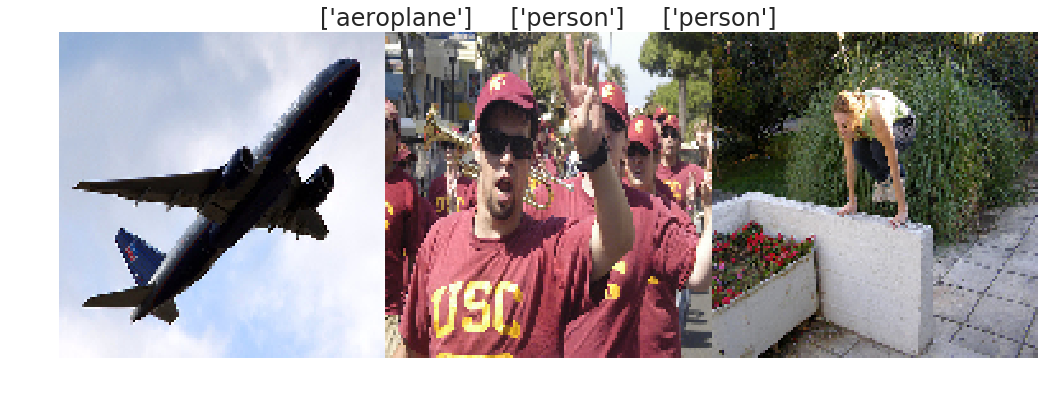

In [16]:
images, labels = next(img_iter)
plt.imshow(np.hstack(images[:3]))
plt.title((' ' * 5).join(str(array_to_labels(x, label_to_class)) for x in labels[:3]))
plt.axis('off');

I will use the `ResNet50` pre-trained model in this example. In order to make things work I will replace the last fully connected layer of the network and replace it for one with 20 neuron units, one for each class. 

* The output layer from `ResNet50` if `include_top=False` has size 2048, I wouldn't normally followed with a fully connected layer of 20 neurons, but for this example is sufficient to show functionality. Normally I try dropping the output units by 1/3 or 1/10 if 1/3 is not sufficient.

In [17]:
def make_model():
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=None,
        pooling='avg'
    )
    for layer in base_model.layers:
        layer.trainable = False

    predictions = Dense(20, activation='sigmoid')(base_model.output)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam'
    )
    return model

model = make_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

It's time for training the model, for a multi-class problem we need the `categorical_crossentropy` loss function with `sigmoid` activation function in the last layer. For fitting the modelwe pass the training iterator and the validation iterator for real-time monitoring during training.

* In contrast with a multi-class problem where we would use a `softmax` activation function in the last layer, here we use a `sigmoid` function. I won't go to the details but basically the probability of each possible label to appear in the image is taken as independent.

### Class weights

In [18]:
total_counts = sum(labels_count.values())
class_weights = {img_iter.class_indices[cls]: total_counts / count for cls, count in labels_count.items()}
class_weights

{14: 2.4770948554732337,
 5: 50.83083511777302,
 2: 29.27003699136868,
 9: 69.81764705882352,
 7: 21.04432624113475,
 8: 17.37774524158126,
 3: 43.23861566484517,
 11: 17.70171513795675,
 18: 40.302207130730054,
 1: 39.366500829187395,
 17: 31.99191374663073,
 19: 36.8031007751938,
 12: 45.129277566539926,
 4: 29.233990147783253,
 15: 38.72430668841762,
 6: 18.48753894080997,
 10: 34.35311143270622,
 16: 66.49299719887955,
 0: 33.1536312849162,
 13: 41.283478260869565}

In [20]:
model = make_model()

metrics = Metrics(img_iter_val, validation_steps=10)
history = model.fit_generator(
    img_iter,
    epochs=1,
    steps_per_epoch=1,
    class_weight=class_weights,
    callbacks=[metrics]
)

Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 19.9103
 - val_f1_score: 0.32590 - val_precision: 0.24642 - val_recall: 0.72069


/home/rodrigo/anaconda3/envs/blogpost/lib/python3.6/site-packages/sklearn/metrics/classification.py:1291: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rodrigo/anaconda3/envs/blogpost/lib/python3.6/site-packages/sklearn/metrics/classification.py:1291: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


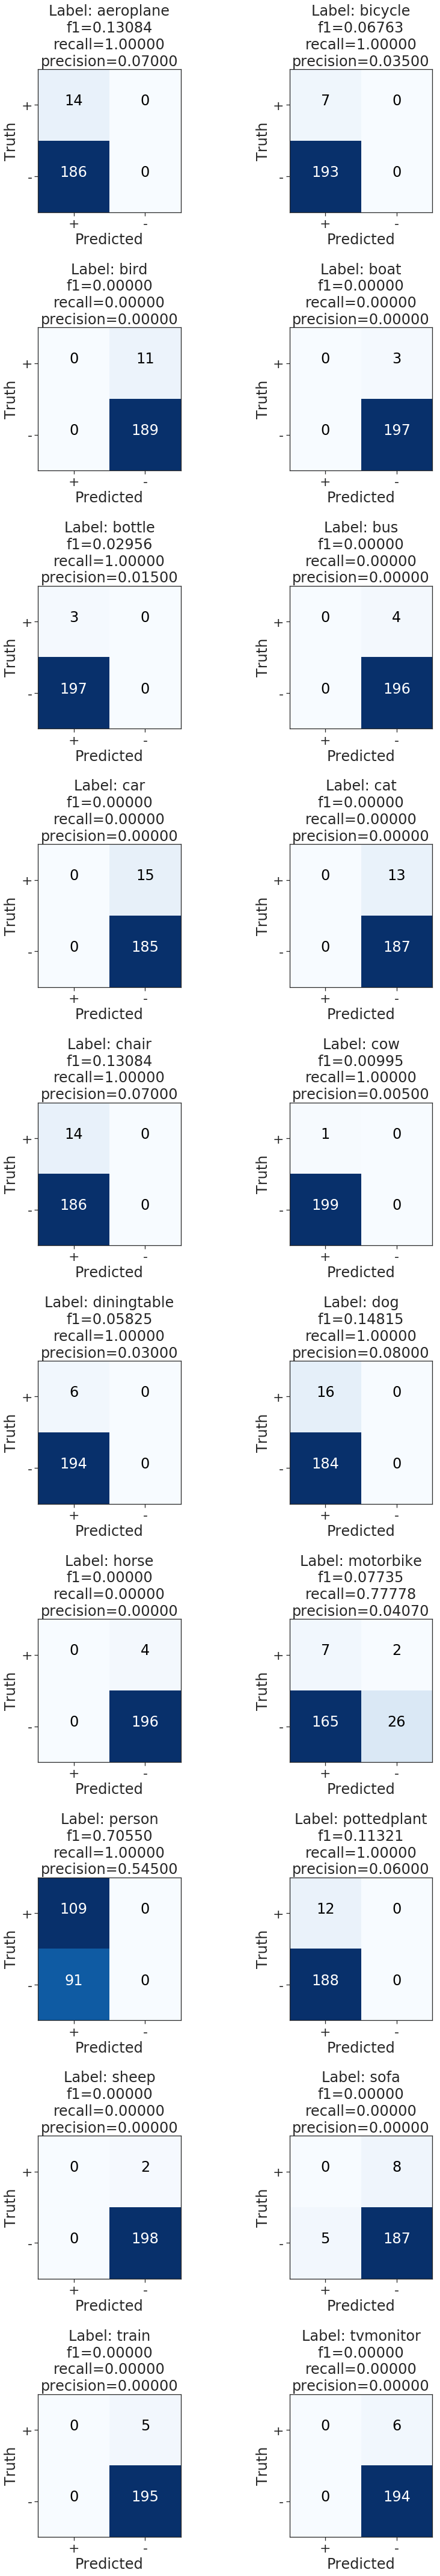

In [21]:
nr_batches = 10
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(img_iter_val, 2)
y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(nr_batches)).astype('int')
y_pred = (model.predict_generator(img_iter_val_1, steps=nr_batches) > threshold).astype('int')
plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False)

In [ ]:
|